# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

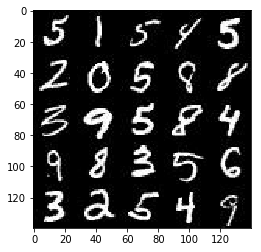

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

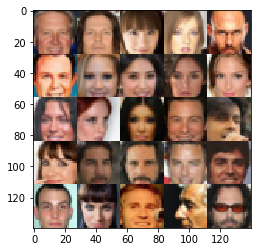

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

strides = 2

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        dim = 64
        #tf.summary.image('images', images)
        x1 = tf.layers.conv2d(images, dim, 5, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #tf.summary.histogram('x1', x1)
        relu1 = leaky_relu(x1)
        #tf.summary.histogram('relu1', relu1)
        
        x2 = tf.layers.conv2d(relu1, 2*dim, 5, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.layers.batch_normalization(x2, training=True)
        #x2 = tf.contrib.layers.layer_norm(x2, trainable=True)
        #tf.summary.histogram('x2', x2)
        relu2 = leaky_relu(x2) #bn2)
        #tf.summary.histogram('relu2', relu2)
        
        x3 = tf.layers.conv2d(relu2, 4*dim, 5, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x3 = tf.layers.batch_normalization(x3, training=True)
        #x3 = tf.contrib.layers.layer_norm(x3, trainable=True)
        #tf.summary.histogram('x3', x3)
        relu3 = leaky_relu(x3) #bn3)
        #tf.summary.histogram('relu3', relu3)
        
        #x4 = tf.layers.conv2d(relu3, 8*dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x4 = tf.contrib.layers.layer_norm(x4, trainable=True) #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = leaky_relu(x4) #bn4)

        flat = tf.contrib.layers.flatten(relu3) #4)
        #tf.summary.histogram('flat', flat)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        dim = 64
        
        width, height, depth = 7, 7, 2*dim
        x1 = tf.layers.dense(z, width*height*depth)
        x1 = tf.reshape(x1, (-1, width, height, depth))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #x1 = leaky_relu(x1)
        tf.summary.histogram('x1', x1)
        
        x2 = tf.layers.conv2d_transpose(x1, dim, 5, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        #x2 = leaky_relu(x2)
        tf.summary.histogram('x2', x2)
        
        #x3 = tf.layers.conv2d_transpose(x2, dim, 5, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.nn.relu(x3)
        #x3 = leaky_relu(x3)
        #tf.summary.histogram('x3', x3)
        
        logits = tf.layers.conv2d_transpose(x2, #x3, 
                                            out_channel_dim, 5, strides=strides, #1, 
                                            padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('logits', logits)
        
        out = tf.tanh(logits)
        #tf.summary.histogram('out', out)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
import numpy as np

#See https://github.com/jiamings/cramer-gan/blob/master/cramer-gan.py

def critic(d_logits, d_logits_fake_baseline):
    return tf.norm(d_logits - d_logits_fake_baseline, axis=1) - tf.norm(d_logits, axis=1)

def model_loss(input_real, input_z, out_channel_dim, epsilon=1.0, input_z2=None):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    tf.summary.histogram('input_z', input_z)
    counterfeit = generator(input_z, out_channel_dim)
    tf.summary.image('counterfeit', counterfeit)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(counterfeit, reuse=True)
    
    # Cramer GAN
    
    # unit test workaround
    if input_z2 is None:
        input_z2 = tf.identity(input_z)
    
    tf.summary.histogram('input_z2', input_z2)
    counterfeit_baseline = generator(input_z2, out_channel_dim, is_train=False)
    tf.summary.image('counterfeit_baseline', counterfeit_baseline)
    d_model_fake_baseline, d_logits_fake_baseline = discriminator(counterfeit_baseline, reuse=True)
    
    #tf.summary.histogram('d_logits_real', d_logits_real)
    #tf.summary.histogram('d_logits_fake', d_logits_fake)
    #tf.summary.histogram('d_logits_fake_baseline', d_logits_fake_baseline)
    
    norm1 = tf.norm(d_logits_real - d_logits_fake, axis=1)
    norm2 = tf.norm(d_logits_real - d_logits_fake_baseline, axis=1)
    norm3 = tf.norm(d_logits_fake - d_logits_fake_baseline, axis=1)
    
    #tf.summary.histogram('norm1', norm1)
    #tf.summary.histogram('norm2', norm2)
    #tf.summary.histogram('norm3', norm3)
    
    g_loss = tf.reduce_mean(norm1 + norm2 - norm3)
    
    surrogate_generator_loss = tf.reduce_mean(critic(d_logits_real, d_logits_fake_baseline) - 
                                              critic(d_logits_fake, d_logits_fake_baseline))
    
    interpolation = epsilon * input_real + (1.0 - epsilon) * counterfeit
    _, d_logits_interpolation = discriminator(interpolation, reuse=True)
    interpolation_critic = critic(d_logits_interpolation, d_logits_fake_baseline)
    
    gradient_norm = tf.norm(tf.gradients(interpolation_critic, interpolation)[0], axis=1)
    LAMBDA = 10.0
    d_loss = -surrogate_generator_loss + LAMBDA * tf.reduce_mean(tf.square(gradient_norm - 1.0))
    
    merged_summary = tf.summary.merge_all()
        
    return d_loss, g_loss, surrogate_generator_loss, merged_summary

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, surrogate_generator_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        surrogate_generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(surrogate_generator_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt, surrogate_generator_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, learning_rate_input = model_inputs(img_width, img_height, img_channels, z_dim)
    input_z2 = tf.placeholder(tf.float32, (None, z_dim))
    
    epsilon = tf.placeholder(tf.float32, input_real.get_shape().as_list()) # WGAN-GP, Cramer GAN
    d_loss, g_loss, surrogate_generator_loss, merged_loss_summary = model_loss(input_real, input_z, img_channels, epsilon, input_z2)
    
    d_opt, g_opt, surrogate_generator_opt = model_opt(d_loss, g_loss, surrogate_generator_loss, learning_rate_input, beta1)
    
    with tf.Session() as sess:
        train_writer = tf.summary.FileWriter('logs/train', sess.graph)
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_number = 1
            for batch_images in get_batches(batch_size):
                
                # rescale from (-0.5, 0.5) defined in helper.py to (-1., 1.)
                normalized_image_batch = 2 * np.array(batch_images, np.float32)

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = np.random.normal(size=(batch_size, z_dim)) # WGAN-GP code used Gaussian noise
                batch_z2 = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # Cramer GAN
                
                ϵ = np.random.uniform(0.0,1.0,size=(batch_size, img_width, img_height, img_channels)) # WGAN-GP & Cramer GAN

                debug_loss_summary = merged_loss_summary.eval({input_z: batch_z, input_z2: batch_z2, input_real: normalized_image_batch, epsilon: ϵ})
                train_writer.add_summary(debug_loss_summary)
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: normalized_image_batch, 
                                               input_z: batch_z, input_z2: batch_z2,
                                               learning_rate_input: learning_rate, epsilon: ϵ})
                critic_iterations = 5 # WGAN 
                if batch_number % critic_iterations == 0:
                    _, _ = sess.run([g_opt, surrogate_generator_opt], 
                                 feed_dict={input_real: normalized_image_batch,
                                            input_z: batch_z, input_z2: batch_z2,
                                            learning_rate_input: learning_rate})
                if batch_number % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, img_channels, data_image_mode)
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_z2: batch_z2, input_real: normalized_image_batch, epsilon: ϵ})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_z2: batch_z2, input_real: normalized_image_batch, epsilon: ϵ})
                    surrogate_train_loss_g = surrogate_generator_loss.eval({input_z: batch_z, input_z2: batch_z2, input_real: normalized_image_batch, epsilon: ϵ})

                    print("Epoch {}/{}, batch {}...".format(epoch_i + 1, epochs, batch_number),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g), 
                          "Surrogate Generator Loss: {:.4f}".format(surrogate_train_loss_g)
                         )
                batch_number += 1
            
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [43]:
batch_size = 64
z_dim = 100
learning_rate = 1e-4 # WGAN-GP recommended value
#learning_rate = 1e-3
#learning_rate = 2e-4
beta1 = 0.5 # WGAN-GP recommended value
#beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

InvalidArgumentError: Nan in summary histogram for: generator_1/logits
	 [[Node: generator_1/logits = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](generator_1/logits/tag, generator_1/conv2d_transpose_2/BiasAdd/_5)]]

Caused by op 'generator_1/logits', defined at:
  File "/opt/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-0d78a346c95a>", line 17, in <module>
    mnist_dataset.shape, mnist_dataset.image_mode)
  File "<ipython-input-11-4f86c3484cde>", line 18, in train
    d_loss, g_loss, surrogate_generator_loss, merged_loss_summary = model_loss(input_real, input_z, img_channels, epsilon, input_z2)
  File "<ipython-input-22-40e4f7d09a3f>", line 30, in model_loss
    counterfeit_baseline = generator(input_z2, out_channel_dim, is_train=False)
  File "<ipython-input-42-daa403c96777>", line 35, in generator
    tf.summary.histogram('logits', logits)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/summary/summary.py", line 209, in histogram
    tag=scope.rstrip('/'), values=values, name=scope)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 139, in _histogram_summary
    name=name)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Nan in summary histogram for: generator_1/logits
	 [[Node: generator_1/logits = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](generator_1/logits/tag, generator_1/conv2d_transpose_2/BiasAdd/_5)]]


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

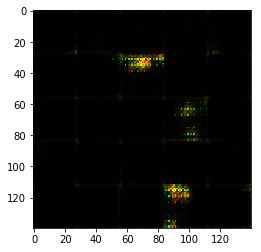

Epoch 1/1, batch 100... Discriminator Loss: 0.4874... Generator Loss: 2.5593


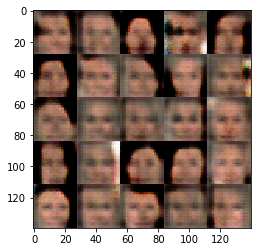

Epoch 1/1, batch 200... Discriminator Loss: 1.4225... Generator Loss: 0.9534


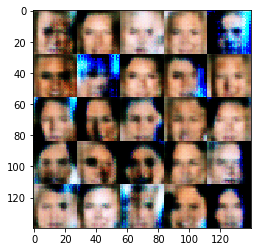

Epoch 1/1, batch 300... Discriminator Loss: 1.3127... Generator Loss: 0.5712


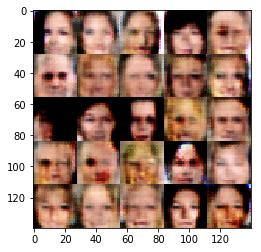

Epoch 1/1, batch 400... Discriminator Loss: 1.2235... Generator Loss: 0.7666


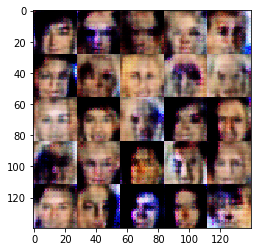

Epoch 1/1, batch 500... Discriminator Loss: 2.1578... Generator Loss: 2.3160


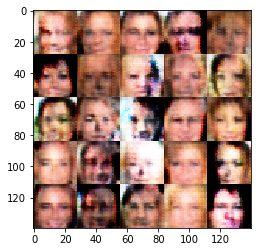

Epoch 1/1, batch 600... Discriminator Loss: 1.3937... Generator Loss: 0.7619


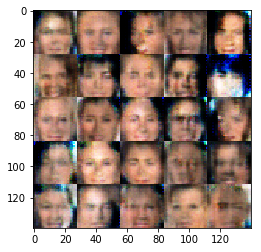

Epoch 1/1, batch 700... Discriminator Loss: 1.4267... Generator Loss: 0.5862


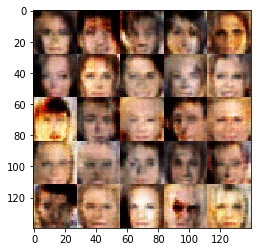

Epoch 1/1, batch 800... Discriminator Loss: 1.3738... Generator Loss: 0.8358


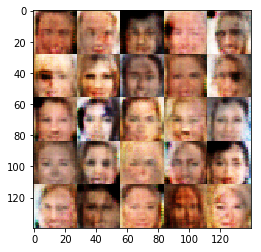

Epoch 1/1, batch 900... Discriminator Loss: 1.2833... Generator Loss: 0.7031


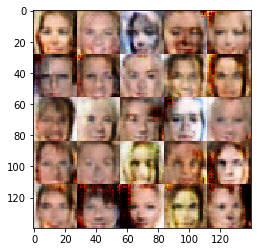

Epoch 1/1, batch 1000... Discriminator Loss: 1.4857... Generator Loss: 1.2066


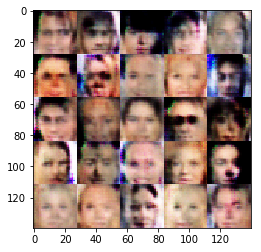

Epoch 1/1, batch 1100... Discriminator Loss: 1.3843... Generator Loss: 0.5102


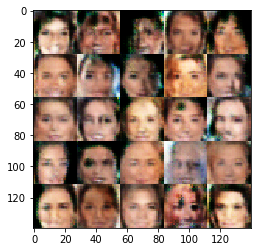

Epoch 1/1, batch 1200... Discriminator Loss: 1.3839... Generator Loss: 0.8614


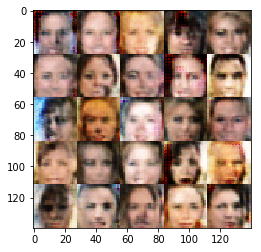

Epoch 1/1, batch 1300... Discriminator Loss: 1.3662... Generator Loss: 0.9068


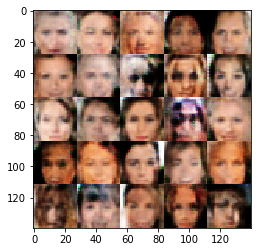

Epoch 1/1, batch 1400... Discriminator Loss: 1.5032... Generator Loss: 0.4381


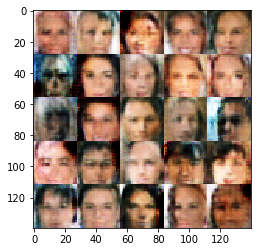

Epoch 1/1, batch 1500... Discriminator Loss: 1.5253... Generator Loss: 0.6111


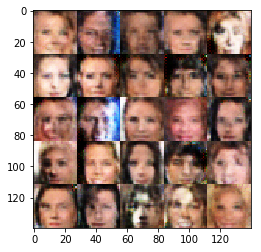

Epoch 1/1, batch 1600... Discriminator Loss: 1.4014... Generator Loss: 0.7253


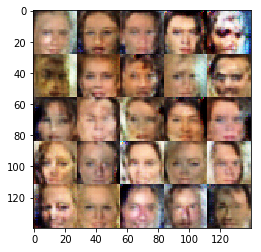

Epoch 1/1, batch 1700... Discriminator Loss: 1.3926... Generator Loss: 0.7803


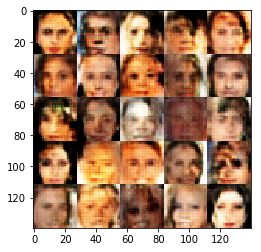

Epoch 1/1, batch 1800... Discriminator Loss: 1.3597... Generator Loss: 0.5412


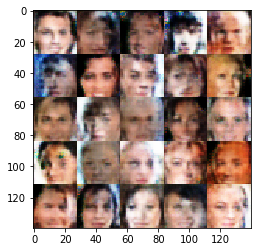

Epoch 1/1, batch 1900... Discriminator Loss: 1.4106... Generator Loss: 0.5623


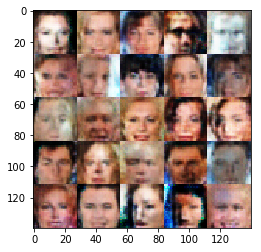

Epoch 1/1, batch 2000... Discriminator Loss: 1.3985... Generator Loss: 0.6021


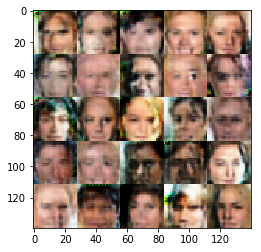

Epoch 1/1, batch 2100... Discriminator Loss: 1.3740... Generator Loss: 0.6660


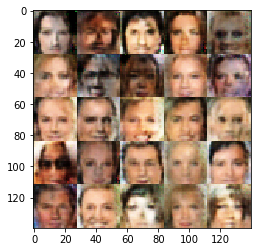

Epoch 1/1, batch 2200... Discriminator Loss: 1.2971... Generator Loss: 0.7272


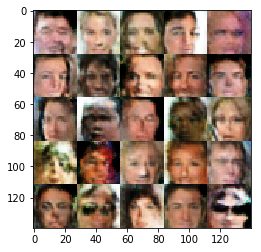

Epoch 1/1, batch 2300... Discriminator Loss: 1.5244... Generator Loss: 0.5308


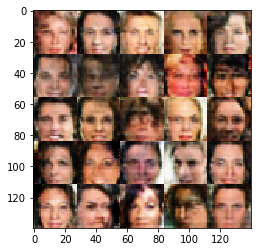

Epoch 1/1, batch 2400... Discriminator Loss: 1.3795... Generator Loss: 0.6193


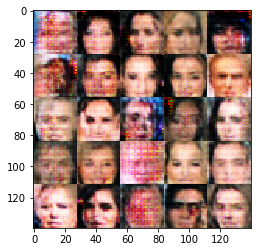

Epoch 1/1, batch 2500... Discriminator Loss: 1.4232... Generator Loss: 0.7970


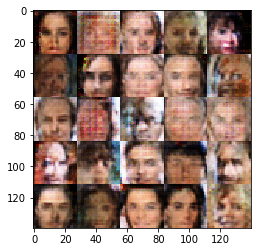

Epoch 1/1, batch 2600... Discriminator Loss: 1.3726... Generator Loss: 0.7996


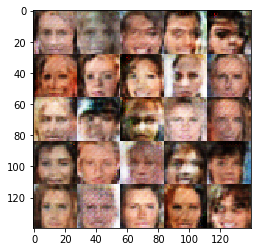

Epoch 1/1, batch 2700... Discriminator Loss: 1.3639... Generator Loss: 0.8004


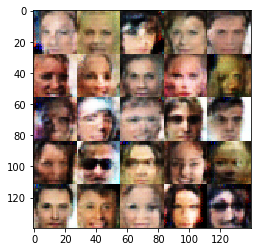

Epoch 1/1, batch 2800... Discriminator Loss: 1.4073... Generator Loss: 0.7195


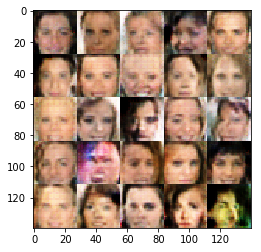

Epoch 1/1, batch 2900... Discriminator Loss: 1.5046... Generator Loss: 0.4507


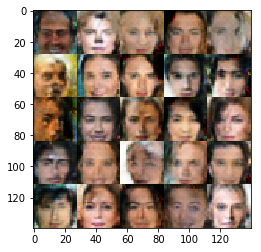

Epoch 1/1, batch 3000... Discriminator Loss: 1.4159... Generator Loss: 0.6366


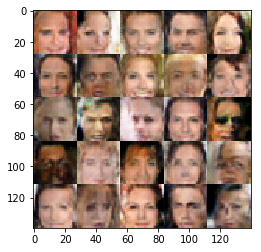

Epoch 1/1, batch 3100... Discriminator Loss: 1.4304... Generator Loss: 1.0770


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 1e-3
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.